### Markov decision process

This week's methods are all built to solve __M__arkov __D__ecision __P__rocesses. In the broadest sense, an MDP is defined by how it changes states and how rewards are computed.

State transition is defined by $P(s' |s,a)$ - how likely are you to end at state $s'$ if you take action $a$ from state $s$. Now there's more than one way to define rewards, but we'll use $r(s,a,s')$ function for convenience.

_This notebook is inspired by the awesome_ [CS294](https://github.com/berkeleydeeprlcourse/homework/blob/36a0b58261acde756abd55306fbe63df226bf62b/hw2/HW2.ipynb) _by Berkeley_

For starters, let's define a simple MDP from this picture:

<img src="https://upload.wikimedia.org/wikipedia/commons/a/ad/Markov_Decision_Process.svg" width="400px" alt="Diagram by Waldoalvarez via Wikimedia Commons, CC BY-SA 4.0"/>

In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/week02_value_based/mdp.py
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

In [2]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's2': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

We can now use MDP just as any other gym environment:

In [3]:
print('initial state =', mdp.reset())
next_state, reward, done, info = mdp.step('a1')
print('next_state = %s, reward = %s, done = %s' % (next_state, reward, done))

initial state = s0
next_state = s2, reward = 0.0, done = False


but it also has other methods that you'll need for Value Iteration

In [4]:
print("mdp.get_all_states =", mdp.get_all_states())
print("mdp.get_possible_actions('s1') = ", mdp.get_possible_actions('s1'))
print("mdp.get_next_states('s1', 'a0') = ", mdp.get_next_states('s1', 'a0'))
print("mdp.get_reward('s1', 'a0', 's0') = ", mdp.get_reward('s1', 'a0', 's0'))
print("mdp.get_transition_prob('s1', 'a0', 's0') = ", mdp.get_transition_prob('s1', 'a0', 's0'))

mdp.get_all_states = ('s0', 's1', 's2')
mdp.get_possible_actions('s1') =  ('a0', 'a1')
mdp.get_next_states('s1', 'a0') =  {'s0': 0.7, 's1': 0.1, 's2': 0.2}
mdp.get_reward('s1', 'a0', 's0') =  5
mdp.get_transition_prob('s1', 'a0', 's0') =  0.7


### Optional: Visualizing MDPs

You can also visualize any MDP with the drawing fuction donated by [neer201](https://github.com/neer201).

You have to install graphviz for system and for python. 

1. * For ubuntu just run: `sudo apt-get install graphviz` 
   * For OSX: `brew install graphviz`
2. `pip install graphviz`
3. restart the notebook

__Note:__ Installing graphviz on some OS (esp. Windows) may be tricky. However, you can ignore this part alltogether and use the standart vizualization.

In [5]:
from mdp import has_graphviz
from IPython.display import display
print("Graphviz available:", has_graphviz)

Graphviz available: True


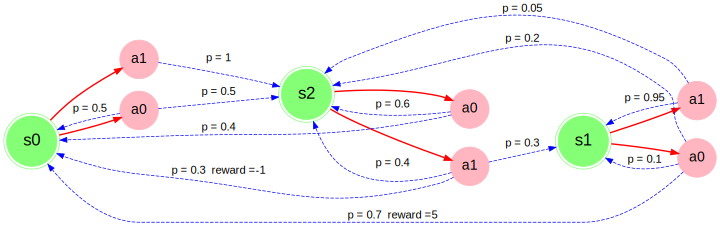

In [6]:
if has_graphviz:
    from mdp import plot_graph, plot_graph_with_state_values, plot_graph_optimal_strategy_and_state_values
    display(plot_graph(mdp))

### Value Iteration

Now let's build something to solve this MDP. The simplest algorithm so far is __V__alue __I__teration

Here's the pseudo-code for VI:

---

`1.` Initialize $V^{(0)}(s)=0$, for all $s$

`2.` For $i=0, 1, 2, \dots$
 
`3.` $ \quad V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$, for all $s$

---

First, let's write a function to compute the state-action value function $Q^{\pi}$, defined as follows

$$Q_i(s, a) = \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')]$$


In [7]:
def get_action_value(mdp, state_values, state, action, gamma):
    """ Computes Q(s,a) as in formula above """

    q_value = 0
    for next_state, proba in mdp.get_next_states(state, action).items():
        reward = mdp.get_reward(state, action, next_state)
        q_value += proba * (reward + gamma * state_values[next_state])

    return q_value

In [8]:
import numpy as np
test_Vs = {s: i for i, s in enumerate(sorted(mdp.get_all_states()))}
assert np.isclose(get_action_value(mdp, test_Vs, 's2', 'a1', 0.9), 0.69)
assert np.isclose(get_action_value(mdp, test_Vs, 's1', 'a0', 0.9), 3.95)

Using $Q(s,a)$ we can now define the "next" V(s) for value iteration.
 $$V_{(i+1)}(s) = \max_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = \max_a Q_i(s,a)$$

In [9]:
def get_new_state_value(mdp, state_values, state, gamma):
    """ Computes next V(s) as in formula above. Please do not change state_values in process. """
    if mdp.is_terminal(state):
        return 0

    actions = mdp.get_possible_actions(state)
    q_values = [get_action_value(mdp, state_values, state, action, gamma) for action in actions]
    
    return max(q_values)

In [10]:
test_Vs_copy = dict(test_Vs)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's0', 0.9), 1.8)
assert np.isclose(get_new_state_value(mdp, test_Vs, 's2', 0.9), 1.08)
assert np.isclose(get_new_state_value(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9), -13500000000.0), \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert test_Vs == test_Vs_copy, "Please do not change state_values in get_new_state_value"

Finally, let's combine everything we wrote into a working value iteration algo.

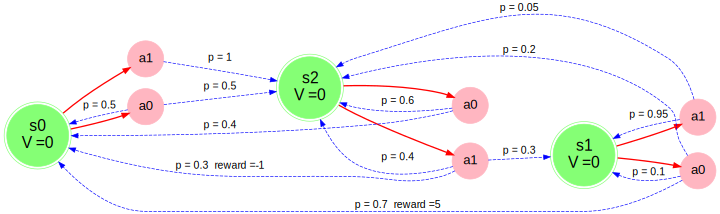

iter    0   |   diff: 3.50000   |   V(s0) = 0.000   V(s1) = 0.000   V(s2) = 0.000
iter    1   |   diff: 0.64500   |   V(s0) = 0.000   V(s1) = 3.500   V(s2) = 0.000
iter    2   |   diff: 0.58050   |   V(s0) = 0.000   V(s1) = 3.815   V(s2) = 0.645
iter    3   |   diff: 0.43582   |   V(s0) = 0.581   V(s1) = 3.959   V(s2) = 0.962
iter    4   |   diff: 0.30634   |   V(s0) = 0.866   V(s1) = 4.395   V(s2) = 1.272
iter    5   |   diff: 0.27571   |   V(s0) = 1.145   V(s1) = 4.670   V(s2) = 1.579
iter    6   |   diff: 0.24347   |   V(s0) = 1.421   V(s1) = 4.926   V(s2) = 1.838
iter    7   |   diff: 0.21419   |   V(s0) = 1.655   V(s1) = 5.169   V(s2) = 2.075
iter    8   |   diff: 0.19277   |   V(s0) = 1.868   V(s1) = 5.381   V(s2) = 2.290
iter    9   |   diff: 0.17327   |   V(s0) = 2.061   V(s1) = 5.573   V(s2) = 2.481
iter   10   |   diff: 0.15569   |   V(s0) = 2.233   V(s1) = 5.746   V(s2) = 2.654
iter   11   |   diff: 0.14012   |   V(s0) = 2.389   V(s1) = 5.902   V(s2) = 2.810
iter   12   |   

In [11]:
# parameters
gamma = 0.9            # discount for MDP
num_iter = 100         # maximum iterations, excluding initialization
# stop VI if new values are this close to old values (or closer)
min_difference = 0.001

# initialize V(s)
state_values = {s: 0 for s in mdp.get_all_states()}

if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

for i in range(num_iter):

    # Compute new state values using the functions you defined above.
    # It must be a dict {state : float V_new(state)}
    new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) for state in mdp.get_all_states()}

    assert isinstance(new_state_values, dict)

    # Compute difference
    diff = max(abs(new_state_values[s] - state_values[s])
               for s in mdp.get_all_states())
    print("iter %4i   |   diff: %6.5f   |   " % (i, diff), end="")
    print('   '.join("V(%s) = %.3f" % (s, v) for s, v in state_values.items()))
    state_values = new_state_values

    if diff < min_difference:
        print("Terminated")
        break

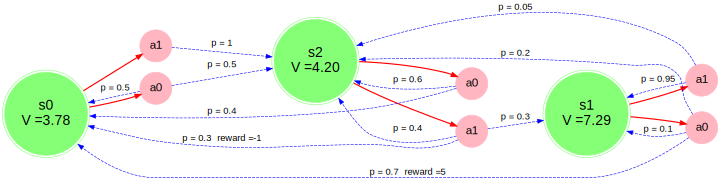

In [12]:
if has_graphviz:
    display(plot_graph_with_state_values(mdp, state_values))

In [13]:
print("Final state values:", state_values)

assert abs(state_values['s0'] - 3.781) < 0.01
assert abs(state_values['s1'] - 7.294) < 0.01
assert abs(state_values['s2'] - 4.202) < 0.01

Final state values: {'s0': 3.7810348735476405, 's1': 7.294006423867229, 's2': 4.202140275227048}


Now let's use those $V^{*}(s)$ to find optimal actions in each state

 $$\pi^*(s) = argmax_a \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{i}(s')] = argmax_a Q_i(s,a)$$
 
The only difference vs V(s) is that here we take not max but argmax: find action such with maximum Q(s,a).

In [14]:
def get_optimal_action(mdp, state_values, state, gamma=0.9):
    """ Finds optimal action using formula above. """
    if mdp.is_terminal(state):
        return None

    actions = mdp.get_possible_actions(state)
    q_vals = [get_action_value(mdp, state_values, state, action, gamma) for action in actions]
    return actions[np.argmax(q_vals)]

In [15]:
assert get_optimal_action(mdp, state_values, 's0', gamma) == 'a1'
assert get_optimal_action(mdp, state_values, 's1', gamma) == 'a0'
assert get_optimal_action(mdp, state_values, 's2', gamma) == 'a1'

assert get_optimal_action(mdp, {'s0': -1e10, 's1': 0, 's2': -2e10}, 's0', 0.9) == 'a0', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"
assert get_optimal_action(mdp, {'s0': -2e10, 's1': 0, 's2': -1e10}, 's0', 0.9) == 'a1', \
    "Please ensure that you handle negative Q-values of arbitrary magnitude correctly"

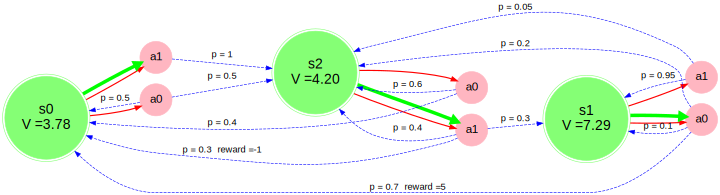

In [16]:
if has_graphviz:
    display(plot_graph_optimal_strategy_and_state_values(mdp, state_values, get_action_value))

In [17]:
# Measure agent's average reward

s = mdp.reset()
rewards = []
for _ in range(10000):
    s, r, done, _ = mdp.step(get_optimal_action(mdp, state_values, s, gamma))
    rewards.append(r)

print("average reward: ", np.mean(rewards))

assert(0.40 < np.mean(rewards) < 0.55)

average reward:  0.4439


### Frozen lake

In [18]:
from mdp import FrozenLakeEnv
mdp = FrozenLakeEnv(slip_chance=0)

mdp.render()

*FFF
FHFH
FFFH
HFFG



In [19]:
def value_iteration(mdp, state_values=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ performs num_iter value iteration steps starting from state_values. Same as before but in a function """
    state_values = state_values or {s: 0 for s in mdp.get_all_states()}
    for i in range(num_iter):

        # Compute new state values using the functions you defined above. It must be a dict {state : new_V(state)}
        new_state_values = {state: get_new_state_value(mdp, state_values, state, gamma) 
                            for state in mdp.get_all_states()}


        assert isinstance(new_state_values, dict)

        # Compute difference
        diff = max(abs(new_state_values[s] - state_values[s])
                   for s in mdp.get_all_states())

        print("iter %4i   |   diff: %6.5f   |   V(start): %.3f " %
              (i, diff, new_state_values[mdp._initial_state]))

        state_values = new_state_values
        if diff < min_difference:
            break

    return state_values

In [20]:
state_values = value_iteration(mdp)

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 


In [21]:
s = mdp.reset()
mdp.render()
for t in range(100):
    a = get_optimal_action(mdp, state_values, s, gamma)
    print(a, end='\n\n')
    s, r, done, _ = mdp.step(a)
    mdp.render()
    if done:
        break

*FFF
FHFH
FFFH
HFFG

down

SFFF
*HFH
FFFH
HFFG

down

SFFF
FHFH
*FFH
HFFG

right

SFFF
FHFH
F*FH
HFFG

down

SFFF
FHFH
FFFH
H*FG

right

SFFF
FHFH
FFFH
HF*G

right

SFFF
FHFH
FFFH
HFF*



### Let's visualize!

It's usually interesting to see what your algorithm actually learned under the hood. To do so, we'll plot state value functions and optimal actions at each VI step.

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline


def draw_policy(mdp, state_values):
    plt.figure(figsize=(3, 3))
    h, w = mdp.desc.shape
    states = sorted(mdp.get_all_states())
    V = np.array([state_values[s] for s in states])
    Pi = {s: get_optimal_action(mdp, state_values, s, gamma) for s in states}
    plt.imshow(V.reshape(w, h), cmap='gray', interpolation='none', clim=(0, 1))
    ax = plt.gca()
    ax.set_xticks(np.arange(h)-.5)
    ax.set_yticks(np.arange(w)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y, X = np.mgrid[0:4, 0:4]
    a2uv = {'left': (-1, 0), 'down': (0, -1), 'right': (1, 0), 'up': (0, 1)}
    for y in range(h):
        for x in range(w):
            plt.text(x, y, str(mdp.desc[y, x].item()),
                     color='g', size=12,  verticalalignment='center',
                     horizontalalignment='center', fontweight='bold')
            a = Pi[y, x]
            if a is None:
                continue
            u, v = a2uv[a]
            plt.arrow(x, y, u*.3, -v*.3, color='m',
                      head_width=0.1, head_length=0.1)
    plt.grid(color='b', lw=2, ls='-')
    plt.show()

after iteration 0
iter    0   |   diff: 1.00000   |   V(start): 0.000 


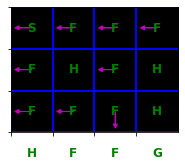

after iteration 1
iter    0   |   diff: 0.90000   |   V(start): 0.000 


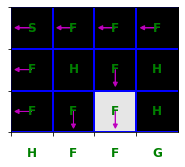

after iteration 2
iter    0   |   diff: 0.81000   |   V(start): 0.000 


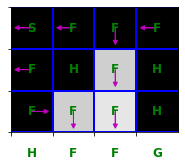

after iteration 3
iter    0   |   diff: 0.72900   |   V(start): 0.000 


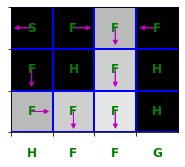

after iteration 4
iter    0   |   diff: 0.65610   |   V(start): 0.000 


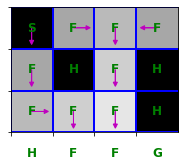

after iteration 5
iter    0   |   diff: 0.59049   |   V(start): 0.590 


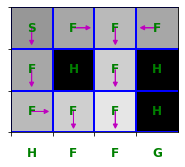

after iteration 6
iter    0   |   diff: 0.00000   |   V(start): 0.590 


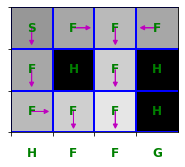

after iteration 7
iter    0   |   diff: 0.00000   |   V(start): 0.590 


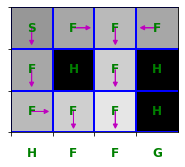

after iteration 8
iter    0   |   diff: 0.00000   |   V(start): 0.590 


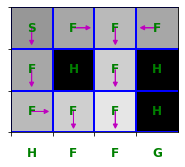

after iteration 9
iter    0   |   diff: 0.00000   |   V(start): 0.590 


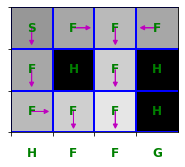

In [23]:
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(10):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
# please ignore iter 0 at each step

after iteration 29
iter    0   |   diff: 0.00000   |   V(start): 0.198 


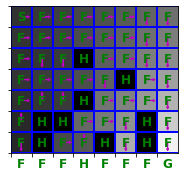

In [24]:
from IPython.display import clear_output
from time import sleep
mdp = FrozenLakeEnv(map_name='8x8', slip_chance=0.1)
state_values = {s: 0 for s in mdp.get_all_states()}

for i in range(30):
    clear_output(True)
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)
    draw_policy(mdp, state_values)
    sleep(0.5)
# please ignore iter 0 at each step

Massive tests

In [25]:
mdp = FrozenLakeEnv(slip_chance=0)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(1.0 <= np.mean(total_rewards) <= 1.0)
print("Well done!")

iter    0   |   diff: 1.00000   |   V(start): 0.000 
iter    1   |   diff: 0.90000   |   V(start): 0.000 
iter    2   |   diff: 0.81000   |   V(start): 0.000 
iter    3   |   diff: 0.72900   |   V(start): 0.000 
iter    4   |   diff: 0.65610   |   V(start): 0.000 
iter    5   |   diff: 0.59049   |   V(start): 0.590 
iter    6   |   diff: 0.00000   |   V(start): 0.590 
average reward:  1.0
Well done!


In [26]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.8 <= np.mean(total_rewards) <= 0.95)
print("Well done!")

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward:  0.865
Well done!


In [27]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.25)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.7)
print("Well done!")

iter    0   |   diff: 0.75000   |   V(start): 0.000 
iter    1   |   diff: 0.50625   |   V(start): 0.000 
iter    2   |   diff: 0.39867   |   V(start): 0.000 
iter    3   |   diff: 0.26910   |   V(start): 0.000 
iter    4   |   diff: 0.18164   |   V(start): 0.000 
iter    5   |   diff: 0.14013   |   V(start): 0.140 
iter    6   |   diff: 0.07028   |   V(start): 0.199 
iter    7   |   diff: 0.06030   |   V(start): 0.260 
iter    8   |   diff: 0.02594   |   V(start): 0.285 
iter    9   |   diff: 0.01918   |   V(start): 0.305 
iter   10   |   diff: 0.00858   |   V(start): 0.313 
iter   11   |   diff: 0.00560   |   V(start): 0.319 
iter   12   |   diff: 0.00260   |   V(start): 0.321 
iter   13   |   diff: 0.00159   |   V(start): 0.323 
iter   14   |   diff: 0.00076   |   V(start): 0.324 
iter   15   |   diff: 0.00045   |   V(start): 0.324 
iter   16   |   diff: 0.00022   |   V(start): 0.324 
iter   17   |   diff: 0.00012   |   V(start): 0.325 
iter   18   |   diff: 0.00006   |   V(start): 

In [28]:
# Measure agent's average reward
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))

print("average reward: ", np.mean(total_rewards))
assert(0.6 <= np.mean(total_rewards) <= 0.8)
print("Well done!")

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

# HW Part 1: Value iteration convergence

### Find an MDP for which value iteration takes long to converge  (1 pts)

When we ran value iteration on the small frozen lake problem, the last iteration where an action changed was iteration 6--i.e., value iteration computed the optimal policy at iteration 6. Are there any guarantees regarding how many iterations it'll take value iteration to compute the optimal policy? There are no such guarantees without additional assumptions--we can construct the MDP in such a way that the greedy policy will change after arbitrarily many iterations.

Your task: define an MDP with at most 3 states and 2 actions, such that when you run value iteration, the optimal action changes at iteration >= 50. Use discount=0.95. (However, note that the discount doesn't matter here--you can construct an appropriate MDP with any discount.)

Note: value function must change at least once after iteration >=50, not necessarily change on every iteration till >=50.

In [29]:
gamma = 0.95

transition_probs = {'s0': {'a0': {'s0': 0.0, 's1': 1.0, 's2': 0.0},
                           'a1': {'s0': 1.0, 's1': 0.0, 's2': 0.0}},
                    's1': {'a0': {'s0': 0.0, 's1': 1.0, 's2': 0.0},
                           'a1': {'s0': 0.0, 's1': 1.0, 's2': 0.0}},
                    's2': {'a0': {'s0': 0.0, 's1': 0.0, 's2': 1.0},
                           'a1': {'s0': 1.0, 's1': 0.0, 's2': 0.0}}}
rewards = {'s0': {'a0': {'s0': 0.5069, 's1': -0.371694, 's2': 0.154432},
                  'a1': {'s0': 1.18911, 's1': -0.139795,'s2': 0.6339995}},
            's1': {'a0': {'s0': -2.12197, 's1': 1.99625,'s2': 0.986387},
                   'a1': {'s0': 0.6361978, 's1': 1.6337968, 's2': 0.019538}},
            's2': {'a0': {'s0': 1.9012172, 's1': 0.7284643, 's2': 1.610708},
                   'a1': {'s0': 0.19977299, 's1': -0.519236, 's2': -1.626}}}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state='s0')
# Feel free to change the initial_state

In [30]:
state_values = {s: 0 for s in mdp.get_all_states()}
policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                   for state in sorted(mdp.get_all_states())])

last_changed = -1
for i in range(100):
    print("after iteration %i" % i)
    state_values = value_iteration(mdp, state_values, num_iter=1)

    new_policy = np.array([get_optimal_action(mdp, state_values, state, gamma)
                           for state in sorted(mdp.get_all_states())])

    n_changes = (policy != new_policy).sum()
    print("N actions changed = %i \n" % n_changes)
    if n_changes > 0:
        last_changed = i
    policy = new_policy

print("Last changed:", last_changed)
# please ignore iter 0 at each step

after iteration 0
iter    0   |   diff: 1.99625   |   V(start): 1.189 
N actions changed = 0 

after iteration 1
iter    0   |   diff: 1.79663   |   V(start): 2.259 
N actions changed = 0 

after iteration 2
iter    0   |   diff: 1.61696   |   V(start): 3.222 
N actions changed = 1 

after iteration 3
iter    0   |   diff: 1.45527   |   V(start): 4.497 
N actions changed = 0 

after iteration 4
iter    0   |   diff: 1.30974   |   V(start): 5.807 
N actions changed = 0 

after iteration 5
iter    0   |   diff: 1.17877   |   V(start): 6.986 
N actions changed = 0 

after iteration 6
iter    0   |   diff: 1.06089   |   V(start): 8.047 
N actions changed = 0 

after iteration 7
iter    0   |   diff: 0.95480   |   V(start): 9.001 
N actions changed = 0 

after iteration 8
iter    0   |   diff: 0.85932   |   V(start): 9.861 
N actions changed = 0 

after iteration 9
iter    0   |   diff: 0.77339   |   V(start): 10.634 
N actions changed = 0 

after iteration 10
iter    0   |   diff: 0.69605 

### Value iteration convervence proof (1 pts)
**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

Update of value function in value iteration can be rewritten in a form of Bellman operator:

$$(TV)(s) = \max_{a \in \mathcal{A}}\mathbb{E}\left[ r_{t+1} + \gamma V(s_{t+1}) | s_t = s, a_t = a\right]$$

Value iteration algorithm with Bellman operator:

---
&nbsp;&nbsp; Initialize $V_0$

&nbsp;&nbsp; **for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; $V_{k+1} \leftarrow TV_k$

&nbsp;&nbsp;**end for**

---

In [lecture](https://docs.google.com/presentation/d/1lz2oIUTvd2MHWKEQSH8hquS66oe4MZ_eRvVViZs2uuE/edit#slide=id.g4fd6bae29e_2_4) we established contraction property of bellman operator:

$$
||TV - TU||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

Using contraction property of Bellman operator, Banach fixed-point theorem and Bellman equations prove that value function converges to $V^*$ in value iterateion$

*Доказательство:* <br>

Применим теорему о неподвижной точке. Заметим, что можно считать, что множество функций V компактно. Это следует из того, что так как множества S и A конечны, а параметр $\gamma < 1$ то все такие функции - ограниченые функции на конечном множестве, то есть просто векторы ограниченной нормы в конечномерном пространстве. По теореме о неподвижной точке сжимающий оператор, действующий на полном (в нашем случае даже компактном) пространстве, при итерации сходится к своей единственной неподвижной точке. А наш алгоритм value iteration - это как раз итерирование оператора Беллмана, который является сжимающим.

### Asynchronious value iteration (2 pts)

Consider the following algorithm:

---

Initialize $V_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Select some state $s_k \in \mathcal{S}$    

&nbsp;&nbsp;&nbsp;&nbsp; $V(s_k) := (TV)(s_k)$

**end for**

---


Note that unlike common value iteration, here we update only a single state at a time.

**Homework.** Prove the following proposition:

If for all $s \in \mathcal{S}$, $s$ appears in the sequence $(s_0, s_1, ...)$ infinitely often, then $V$ converges to $V*$

*<-- Your proof here -->*


*Доказательство:* <br>

Мы опять предполагаем, что множества S и A конечны. Так как все состояния встречаются в последовательности $(s_0, s_1, ...)$ бесконечно много раз, то эту последовательность можно разбить на конечные участки $(s_{k_i+1}, \ldots, s_{k_{i+1}})$, каждый из которых содержит все состояния из S:

$(s_0, s_1, \ldots, s_{k_1}, s_{k_1 + 1}, \ldots, s_{k_2}, \ldots)$.

Тогда для этого разбиения мы будем итерировать оператор $T$ внутри кажого участка. Например, для участка
$(s_{k_i+1}, \ldots, s_{k_{i+1}})$ мы рассмотриваем оператор $T^{k_{i+1} - k_i}$ (мы его итерируем $k_{i+1} - k_i$ раз). Покажем, что этот оператор является сжимающим. Рассмотрим

$$
\|T^{k_{i+1} - k_i} V - T^{k_{i+1} - k_i} U\|_{\infty} = \max_{s \in S} \Big|T^{k_{i+1} - k_i} V(s) - T^{k_{i+1} - k_i} U(s)\Big|.
$$
Так как на рассматриваем участке встречаются все состояния хотя бы 1 раз, то для каждого $s$
$$
\big|T^{k_{i+1} - k_i} V(s) - T^{k_{i+1} - k_i} U(s)\big| \leq \gamma \big|V(s) - U(s)\big|,
$$
откуда 
$$
\|T^{k_{i+1} - k_i} V - T^{k_{i+1} - k_i} U\|_{\infty} \leq \gamma \|V - U\|_{\infty}.
$$
Следовательно, можно применить ту же технику, что и в теореме Банаха о неподвижной точке: построить последовательность итераций и показать, что эта последовательность является последовательностью Коши, то есть сходится к $V_*$.

# HW Part 2: Policy iteration

## Policy iteration implementateion (3 pts)

Let's implement exact policy iteration (PI), which has the following pseudocode:

---
Initialize $\pi_0$   `// random or fixed action`

For $n=0, 1, 2, \dots$
- Compute the state-value function $V^{\pi_{n}}$
- Using $V^{\pi_{n}}$, compute the state-action-value function $Q^{\pi_{n}}$
- Compute new policy $\pi_{n+1}(s) = \operatorname*{argmax}_a Q^{\pi_{n}}(s,a)$
---

Unlike VI, policy iteration has to maintain a policy - chosen actions from all states - and estimate $V^{\pi_{n}}$ based on this policy. It only changes policy once values converged.


Below are a few helpers that you may or may not use in your implementation.

In [31]:
transition_probs = {
    's0': {
        'a0': {'s0': 0.5, 's2': 0.5},
        'a1': {'s2': 1}
    },
    's1': {
        'a0': {'s0': 0.7, 's1': 0.1, 's2': 0.2},
        'a1': {'s1': 0.95, 's2': 0.05}
    },
    's2': {
        'a0': {'s0': 0.4, 's1': 0.6},
        'a1': {'s0': 0.3, 's1': 0.3, 's2': 0.4}
    }
}
rewards = {
    's1': {'a0': {'s0': +5}},
    's2': {'a1': {'s0': -1}}
}

from mdp import MDP
mdp = MDP(transition_probs, rewards, initial_state='s0')

Let's write a function called `compute_vpi` that computes the state-value function $V^{\pi}$ for an arbitrary policy $\pi$.

Unlike VI, this time you must find the exact solution, not just a single iteration.

Recall that $V^{\pi}$ satisfies the following linear equation:
$$V^{\pi}(s) = \sum_{s'} P(s,\pi(s),s')[ R(s,\pi(s),s') + \gamma V^{\pi}(s')]$$

You'll have to solve a linear system in your code. (Find an exact solution, e.g., with `np.linalg.solve`.)

In [32]:
def compute_vpi(mdp, policy, gamma):
    """
    Computes V^pi(s) FOR ALL STATES under given policy.
    :param policy: a dict of currently chosen actions {s : a}
    :returns: a dict {state : V^pi(state) for all states}
    """
    all_states = mdp.get_all_states()
    state_idx = {state: i for (i, state) in enumerate(all_states)}
    A = np.eye(len(all_states), dtype=float)
    b = np.zeros(len(all_states), dtype=float)

    for i, state in enumerate(all_states):
        if state in policy:
            for next_state, proba in mdp.get_next_states(state, policy[state]).items():
                A[i, state_idx[next_state]] -= gamma *  proba
                b[i] += mdp.get_reward(state, policy[state], next_state) * proba

    solution = np.linalg.solve(A, b)
    return {state: solution[i] for i, state in enumerate(all_states)}

In [33]:
test_policy = {s: np.random.choice(
    mdp.get_possible_actions(s)) for s in mdp.get_all_states()}
new_vpi = compute_vpi(mdp, test_policy, gamma)

print("Solution:", new_vpi)

assert type(
    new_vpi) is dict, "compute_vpi must return a dict {state : V^pi(state) for all states}"

Solution: {'s0': 0.0, 's1': -0.0, 's2': 0.0}


In [34]:
all_states = mdp.get_all_states()
for i, state in enumerate(all_states):
    sm = 0
    if state in test_policy:
        for j, (next_state, proba) in enumerate(mdp.get_next_states(state, test_policy[state]).items()):
            sm += proba * (mdp.get_reward(state, test_policy[state], next_state) + gamma * new_vpi[next_state])
    print(sm)

0.0
0.0
0.0


Once we've got new state values, it's time to update our policy.

In [35]:
def compute_new_policy(mdp, vpi, gamma):
    """
    Computes new policy as argmax of state values
    :param vpi: a dict {state : V^pi(state) for all states}
    :returns: a dict {state : optimal action for all states}
    """
    
    new_policy = {}
    for state in mdp.get_all_states():
        actions = mdp.get_possible_actions(state)
        q_vals = [get_action_value(mdp, vpi, state, action, gamma) for action in actions]
        if q_vals:
            new_policy[state] = actions[np.argmax(q_vals)]

    return new_policy

In [36]:
new_policy = compute_new_policy(mdp, new_vpi, gamma)

print(new_policy)

assert type(
    new_policy) is dict, "compute_new_policy must return a dict {state : optimal action for all states}"

{'s0': 'a0', 's1': 'a0', 's2': 'a0'}


__Main loop__

In [37]:
def policy_iteration(mdp, policy=None, gamma=0.9, num_iter=1000, min_difference=1e-5):
    """ 
    Run the policy iteration loop for num_iter iterations or till difference between V(s) is below min_difference.
    If policy is not given, initialize it at random.
    """
    if policy is None:
        policy = {s: np.random.choice(mdp.get_possible_actions(s)) for s in mdp.get_all_states() 
                  if mdp.get_possible_actions(s)}
    vpi = compute_vpi(mdp, policy, gamma)

    for it in range(num_iter):
        policy = compute_new_policy(mdp, vpi, gamma)
        state_values = compute_vpi(mdp, policy, gamma)
        diff = max(abs(vpi[s] - state_values[s]) for s in mdp.get_all_states())
        if diff < min_difference:
            break
        import copy
        vpi = copy.deepcopy(state_values)
    print('converged after %d iteration(s)' % (it + 1))

    return state_values, policy

__Your PI Results__

In [38]:
#compare PI and VI on the MDP from bonus 1, then on small & large FrozenLake>

In [39]:
# Первый пример:
state_values, policy = policy_iteration(mdp)
state_values, policy

converged after 3 iteration(s)


({'s0': 8.031919916894896, 's1': 11.171970913211828, 's2': 8.924355463216552},
 {'s0': 'a1', 's1': 'a0', 's2': 'a0'})

In [40]:
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of VI: ", np.mean(total_rewards))

iter    0   |   diff: 3.50000   |   V(start): 0.000 
iter    1   |   diff: 1.89000   |   V(start): 0.000 
iter    2   |   diff: 1.70100   |   V(start): 1.701 
iter    3   |   diff: 1.13542   |   V(start): 1.854 
iter    4   |   diff: 0.73024   |   V(start): 2.584 
iter    5   |   diff: 0.61135   |   V(start): 3.186 
iter    6   |   diff: 0.54664   |   V(start): 3.590 
iter    7   |   diff: 0.49198   |   V(start): 4.082 
iter    8   |   diff: 0.42210   |   V(start): 4.463 
iter    9   |   diff: 0.36513   |   V(start): 4.816 
iter   10   |   diff: 0.32862   |   V(start): 5.145 
iter   11   |   diff: 0.29262   |   V(start): 5.429 
iter   12   |   diff: 0.26189   |   V(start): 5.691 
iter   13   |   diff: 0.23503   |   V(start): 5.925 
iter   14   |   diff: 0.21124   |   V(start): 6.135 
iter   15   |   diff: 0.19012   |   V(start): 6.325 
iter   16   |   diff: 0.17091   |   V(start): 6.496 
iter   17   |   diff: 0.15366   |   V(start): 6.649 
iter   18   |   diff: 0.13830   |   V(start): 

In [41]:
_, policy = policy_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of PI: ", np.mean(total_rewards))

converged after 1 iteration(s)
average reward of PI:  91.33


In [42]:
# Первая ДЗ
transition_probs = {'s0': {'a0': {'s0': 0.0, 's1': 1.0, 's2': 0.0},
                           'a1': {'s0': 1.0, 's1': 0.0, 's2': 0.0}},
                    's1': {'a0': {'s0': 0.0, 's1': 1.0, 's2': 0.0},
                           'a1': {'s0': 0.0, 's1': 1.0, 's2': 0.0}},
                    's2': {'a0': {'s0': 0.0, 's1': 0.0, 's2': 1.0},
                           'a1': {'s0': 1.0, 's1': 0.0, 's2': 0.0}}}
rewards = {'s0': {'a0': {'s0': 0.5, 's1': -0.37, 's2': 0.15},
                  'a1': {'s0': 1.2, 's1': -0.14, 's2': 0.63}},
           's1': {'a0': {'s0': -2.12, 's1': 2.0, 's2': 0.99},
                  'a1': {'s0': 0.64, 's1': 1.63, 's2': 0.02}},
           's2': {'a0': {'s0': 1.9, 's1': 0.73, 's2': 1.6},
                  'a1': {'s0': 0.2, 's1': -0.52, 's2': -1.63}}}

from mdp import MDP
from numpy import random
mdp = MDP(transition_probs, rewards, initial_state='s0')

state_values, policy = policy_iteration(mdp)

converged after 3 iteration(s)


In [43]:
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of VI: ", np.mean(total_rewards))

iter    0   |   diff: 2.00000   |   V(start): 1.200 
iter    1   |   diff: 1.80000   |   V(start): 2.280 
iter    2   |   diff: 1.62000   |   V(start): 3.252 
iter    3   |   diff: 1.45800   |   V(start): 4.508 
iter    4   |   diff: 1.31220   |   V(start): 5.820 
iter    5   |   diff: 1.18098   |   V(start): 7.001 
iter    6   |   diff: 1.06288   |   V(start): 8.064 
iter    7   |   diff: 0.95659   |   V(start): 9.021 
iter    8   |   diff: 0.86093   |   V(start): 9.882 
iter    9   |   diff: 0.77484   |   V(start): 10.656 
iter   10   |   diff: 0.69736   |   V(start): 11.354 
iter   11   |   diff: 0.62762   |   V(start): 11.981 
iter   12   |   diff: 0.56486   |   V(start): 12.546 
iter   13   |   diff: 0.50837   |   V(start): 13.055 
iter   14   |   diff: 0.45754   |   V(start): 13.512 
iter   15   |   diff: 0.41178   |   V(start): 13.924 
iter   16   |   diff: 0.37060   |   V(start): 14.295 
iter   17   |   diff: 0.33354   |   V(start): 14.628 
iter   18   |   diff: 0.30019   |   V

In [44]:
_, policy = policy_iteration(mdp, num_iter=1000)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of PI: ", np.mean(total_rewards))

converged after 3 iteration(s)
average reward of PI:  197.63000000000005


In [45]:
# FrozenLake
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values, policy = policy_iteration(mdp)

converged after 4 iteration(s)


In [46]:
mdp = FrozenLakeEnv(slip_chance=0.1)
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of VI: ", np.mean(total_rewards))

iter    0   |   diff: 0.90000   |   V(start): 0.000 
iter    1   |   diff: 0.72900   |   V(start): 0.000 
iter    2   |   diff: 0.62330   |   V(start): 0.000 
iter    3   |   diff: 0.50487   |   V(start): 0.000 
iter    4   |   diff: 0.40894   |   V(start): 0.000 
iter    5   |   diff: 0.34868   |   V(start): 0.349 
iter    6   |   diff: 0.06529   |   V(start): 0.410 
iter    7   |   diff: 0.05832   |   V(start): 0.468 
iter    8   |   diff: 0.01139   |   V(start): 0.480 
iter    9   |   diff: 0.00764   |   V(start): 0.487 
iter   10   |   diff: 0.00164   |   V(start): 0.489 
iter   11   |   diff: 0.00094   |   V(start): 0.490 
iter   12   |   diff: 0.00022   |   V(start): 0.490 
iter   13   |   diff: 0.00011   |   V(start): 0.490 
iter   14   |   diff: 0.00003   |   V(start): 0.490 
iter   15   |   diff: 0.00001   |   V(start): 0.490 
iter   16   |   diff: 0.00000   |   V(start): 0.490 
average reward of VI:  0.889


In [47]:
mdp = FrozenLakeEnv(slip_chance=0.1)
get_optimal_action(mdp, state_values, s, gamma)

In [48]:
mdp = FrozenLakeEnv(slip_chance=0.1)
_, policy = policy_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of PI: ", np.mean(total_rewards))

converged after 3 iteration(s)
average reward of PI:  0.886


converged after 6 iteration(s)
after iteration 0
converged after 6 iteration(s)


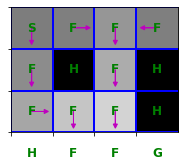

after iteration 1
converged after 1 iteration(s)


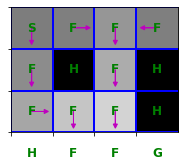

after iteration 2
converged after 1 iteration(s)


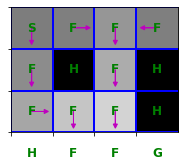

after iteration 3
converged after 1 iteration(s)


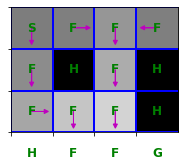

after iteration 4
converged after 1 iteration(s)


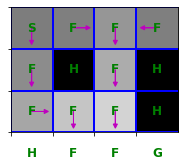

after iteration 5
converged after 1 iteration(s)


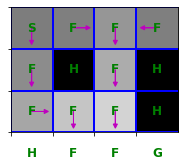

after iteration 6
converged after 1 iteration(s)


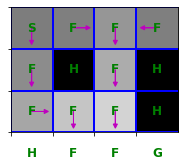

after iteration 7
converged after 1 iteration(s)


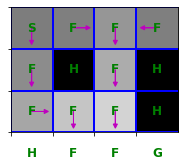

after iteration 8
converged after 1 iteration(s)


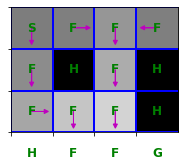

after iteration 9
converged after 1 iteration(s)


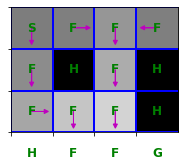

after iteration 10
converged after 1 iteration(s)


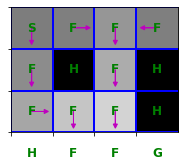

after iteration 11
converged after 1 iteration(s)


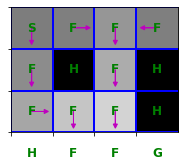

after iteration 12
converged after 1 iteration(s)


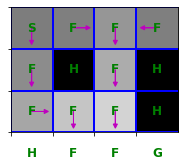

after iteration 13
converged after 1 iteration(s)


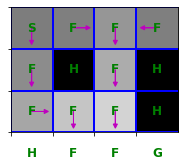

after iteration 14
converged after 1 iteration(s)


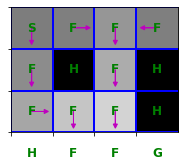

after iteration 15
converged after 1 iteration(s)


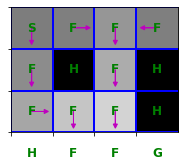

after iteration 16
converged after 1 iteration(s)


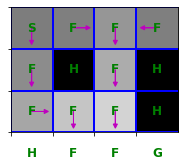

after iteration 17
converged after 1 iteration(s)


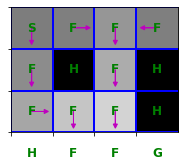

after iteration 18
converged after 1 iteration(s)


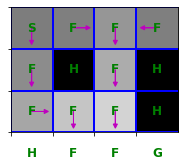

after iteration 19
converged after 1 iteration(s)


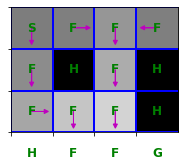

after iteration 20
converged after 1 iteration(s)


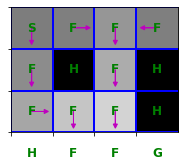

after iteration 21
converged after 1 iteration(s)


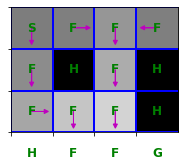

after iteration 22
converged after 1 iteration(s)


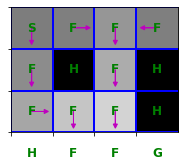

after iteration 23
converged after 1 iteration(s)


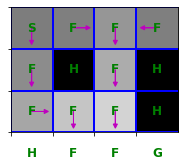

after iteration 24
converged after 1 iteration(s)


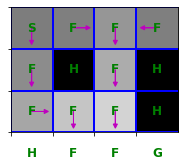

after iteration 25
converged after 1 iteration(s)


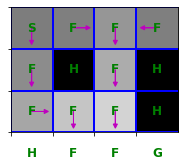

after iteration 26
converged after 1 iteration(s)


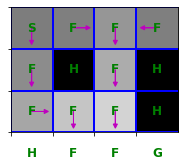

after iteration 27
converged after 1 iteration(s)


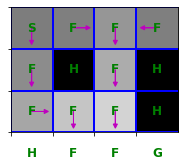

after iteration 28
converged after 1 iteration(s)


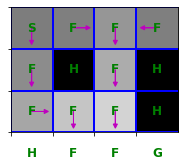

after iteration 29
converged after 1 iteration(s)


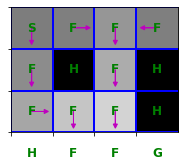

after iteration 30
converged after 1 iteration(s)


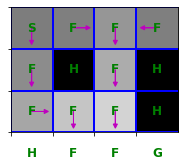

after iteration 31
converged after 1 iteration(s)


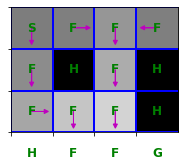

after iteration 32
converged after 1 iteration(s)


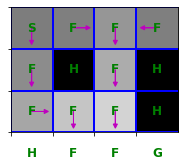

after iteration 33
converged after 1 iteration(s)


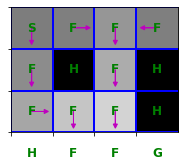

after iteration 34
converged after 1 iteration(s)


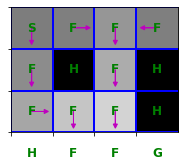

after iteration 35
converged after 1 iteration(s)


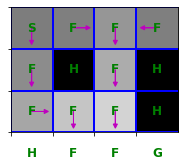

after iteration 36
converged after 1 iteration(s)


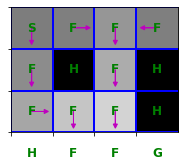

after iteration 37
converged after 1 iteration(s)


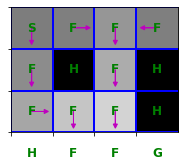

after iteration 38
converged after 1 iteration(s)


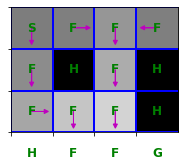

after iteration 39
converged after 1 iteration(s)


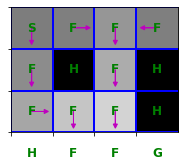

after iteration 40
converged after 1 iteration(s)


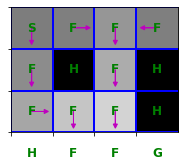

after iteration 41
converged after 1 iteration(s)


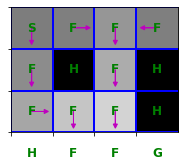

after iteration 42
converged after 1 iteration(s)


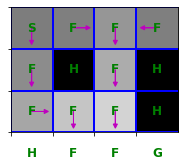

after iteration 43
converged after 1 iteration(s)


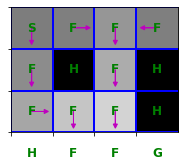

after iteration 44
converged after 1 iteration(s)


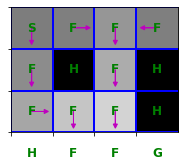

after iteration 45
converged after 1 iteration(s)


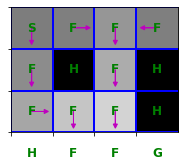

after iteration 46
converged after 1 iteration(s)


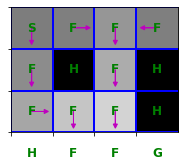

after iteration 47
converged after 1 iteration(s)


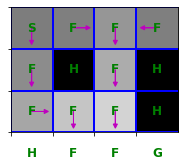

after iteration 48
converged after 1 iteration(s)


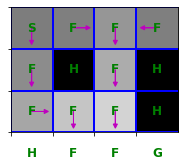

after iteration 49
converged after 1 iteration(s)


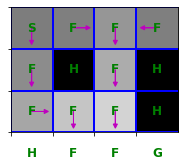

after iteration 50
converged after 1 iteration(s)


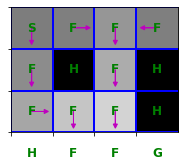

after iteration 51
converged after 1 iteration(s)


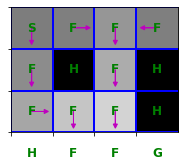

after iteration 52
converged after 1 iteration(s)


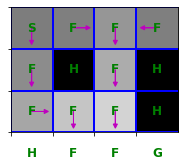

after iteration 53
converged after 1 iteration(s)


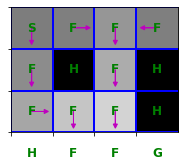

after iteration 54
converged after 1 iteration(s)


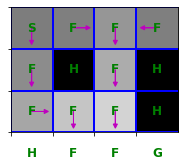

after iteration 55
converged after 1 iteration(s)


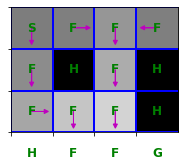

after iteration 56
converged after 1 iteration(s)


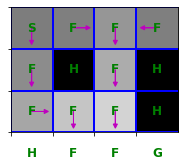

after iteration 57
converged after 1 iteration(s)


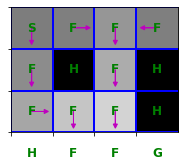

after iteration 58
converged after 1 iteration(s)


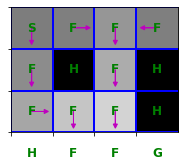

after iteration 59
converged after 1 iteration(s)


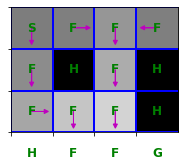

after iteration 60
converged after 1 iteration(s)


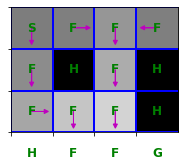

after iteration 61
converged after 1 iteration(s)


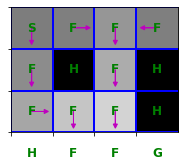

after iteration 62
converged after 1 iteration(s)


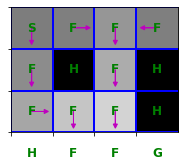

after iteration 63
converged after 1 iteration(s)


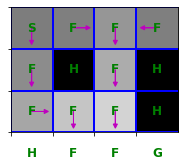

after iteration 64
converged after 1 iteration(s)


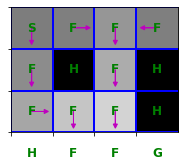

after iteration 65
converged after 1 iteration(s)


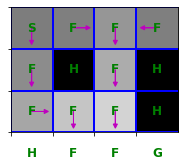

after iteration 66
converged after 1 iteration(s)


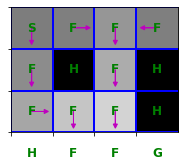

after iteration 67
converged after 1 iteration(s)


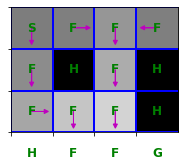

after iteration 68
converged after 1 iteration(s)


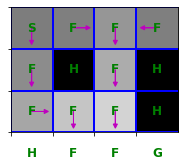

after iteration 69
converged after 1 iteration(s)


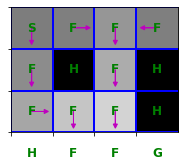

after iteration 70
converged after 1 iteration(s)


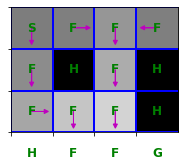

after iteration 71
converged after 1 iteration(s)


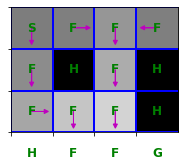

after iteration 72
converged after 1 iteration(s)


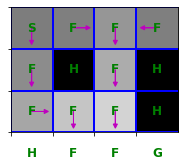

after iteration 73
converged after 1 iteration(s)


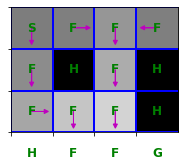

after iteration 74
converged after 1 iteration(s)


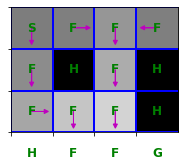

after iteration 75
converged after 1 iteration(s)


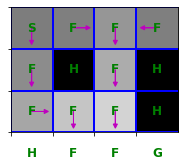

after iteration 76
converged after 1 iteration(s)


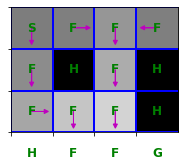

after iteration 77
converged after 1 iteration(s)


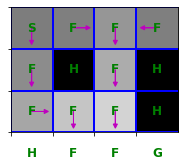

after iteration 78
converged after 1 iteration(s)


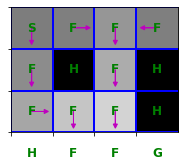

after iteration 79
converged after 1 iteration(s)


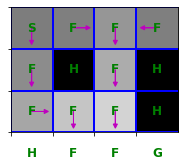

after iteration 80
converged after 1 iteration(s)


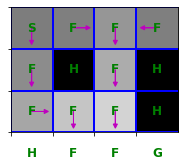

after iteration 81
converged after 1 iteration(s)


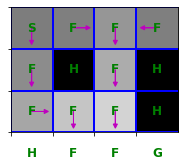

after iteration 82
converged after 1 iteration(s)


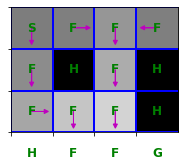

after iteration 83
converged after 1 iteration(s)


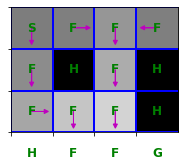

after iteration 84
converged after 1 iteration(s)


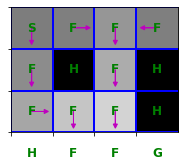

after iteration 85
converged after 1 iteration(s)


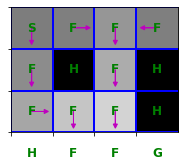

after iteration 86
converged after 1 iteration(s)


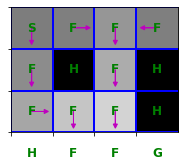

after iteration 87
converged after 1 iteration(s)


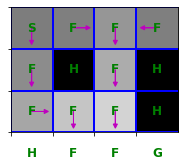

after iteration 88
converged after 1 iteration(s)


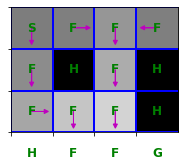

after iteration 89
converged after 1 iteration(s)


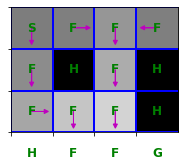

after iteration 90
converged after 1 iteration(s)


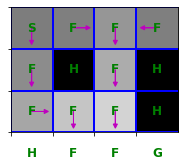

after iteration 91
converged after 1 iteration(s)


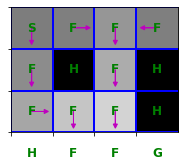

after iteration 92
converged after 1 iteration(s)


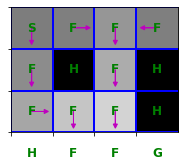

after iteration 93
converged after 1 iteration(s)


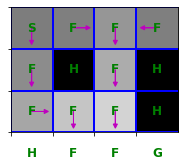

after iteration 94
converged after 1 iteration(s)


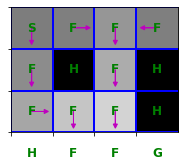

after iteration 95
converged after 1 iteration(s)


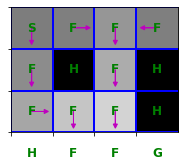

after iteration 96
converged after 1 iteration(s)


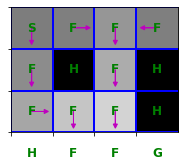

after iteration 97
converged after 1 iteration(s)


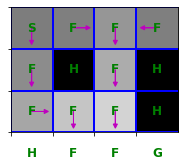

after iteration 98
converged after 1 iteration(s)


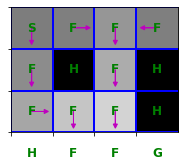

after iteration 99
converged after 1 iteration(s)


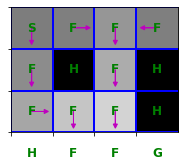

In [49]:
mdp = FrozenLakeEnv(slip_chance=0.1)
_, policy = policy_iteration(mdp)

policy = None

for i in range(100):
    print("after iteration %i" % i)
    state_values, policy  = policy_iteration(mdp, policy=policy)
    draw_policy(mdp, state_values)

In [50]:
# Large FrozenLake
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values, policy = policy_iteration(mdp)

converged after 6 iteration(s)


In [51]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
state_values = value_iteration(mdp)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(
            get_optimal_action(mdp, state_values, s, gamma))
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of VI: ", np.mean(total_rewards))

iter    0   |   diff: 0.80000   |   V(start): 0.000 
iter    1   |   diff: 0.57600   |   V(start): 0.000 
iter    2   |   diff: 0.41472   |   V(start): 0.000 
iter    3   |   diff: 0.29860   |   V(start): 0.000 
iter    4   |   diff: 0.24186   |   V(start): 0.000 
iter    5   |   diff: 0.19349   |   V(start): 0.000 
iter    6   |   diff: 0.15325   |   V(start): 0.000 
iter    7   |   diff: 0.12288   |   V(start): 0.000 
iter    8   |   diff: 0.09930   |   V(start): 0.000 
iter    9   |   diff: 0.08037   |   V(start): 0.000 
iter   10   |   diff: 0.06426   |   V(start): 0.000 
iter   11   |   diff: 0.05129   |   V(start): 0.000 
iter   12   |   diff: 0.04330   |   V(start): 0.000 
iter   13   |   diff: 0.03802   |   V(start): 0.033 
iter   14   |   diff: 0.03332   |   V(start): 0.058 
iter   15   |   diff: 0.02910   |   V(start): 0.087 
iter   16   |   diff: 0.01855   |   V(start): 0.106 
iter   17   |   diff: 0.01403   |   V(start): 0.120 
iter   18   |   diff: 0.00810   |   V(start): 

In [52]:
mdp = FrozenLakeEnv(slip_chance=0.2, map_name='8x8')
_, policy = policy_iteration(mdp, min_difference=1e-8)

total_rewards = []
for game_i in range(1000):
    s = mdp.reset()
    rewards = []
    for t in range(100):
        s, r, done, _ = mdp.step(policy[s])
        rewards.append(r)
        if done:
            break
    total_rewards.append(np.sum(rewards))
print("average reward of PI: ", np.mean(total_rewards))

converged after 8 iteration(s)
average reward of PI:  0.755


Вывод: Оба метода сходятся, как и гарантирует теория. Policy Iteration работает заметно быстрее (в терминах числа итераций), чем Value Iterations. 

## Policy iteration convergence (3 pts)

**Note:** Assume that $\mathcal{S}, \mathcal{A}$ are finite.

We can define another Bellman operator:

$$(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right]$$

And rewrite policy iteration algorithm in operator form:


---

Initialize $\pi_0$

**for** $k = 0,1,2,...$ **do**

&nbsp;&nbsp;&nbsp;&nbsp; Solve $V_k = T_{\pi_k}V_k$   

&nbsp;&nbsp;&nbsp;&nbsp; Select $\pi_{k+1}$ s.t. $T_{\pi_{k+1}}V_k = TV_k$ 

**end for**

---

To prove convergence of the algorithm we need to prove two properties: contraction an monotonicity.

#### Monotonicity (0.5 pts)

For all $V, U$ if $V(s) \le U(s)$   $\forall s \in \mathcal{S}$ then $(T_\pi V)(s) \le (T_\pi U)(s)$   $\forall s \in  \mathcal{S}$

*Решение:* <br>

Имеем 
$$
(T_{\pi}V)(s) = \mathbb{E}_{r, s'|s, a = \pi(s)}\left[r + \gamma V(s')\right],
$$
то $\forall s \in  \mathcal{S}$
$$
(T_\pi V)(s) - (T_\pi U)(s) = \gamma \mathbb{E}_{s'|s, a = \pi(s)}\left[ V(s') - U(s')\right] \leq 0,
$$
так как внутри математического ожидания по условию неположительная случайная величина.

#### Contraction (1 pts)

$$
||T_\pi V - T_\pi U||_{\infty} \le \gamma ||V - U||_{\infty}
$$

For all $V, U$

*Решение:* <br>

Было показано, что
$$
(T_\pi V)(s) - (T_\pi U)(s) = \gamma \mathbb{E}_{s'|s, a = \pi(s)}\left[ V(s') - U(s')\right] \leq 0,
$$
Отсюда следует, что 
$$
\|T_\pi V - T_\pi U\|_{\infty} = \big| \gamma \mathbb{E}_{s'|s, a = \pi(s)}\left[ V(s') - U(s')\right]\big|_{\infty} \leq  \gamma \mathbb{E}_{s'|s, a = \pi(s)} \| V - U \|_{\infty} = \gamma ||V - U||_{\infty}.
$$

#### Convergence (1.5 pts)

Prove that there exists iteration $k_0$ such that $\pi_k = \pi^*$ for all $k \ge k_0$


*Решение:* <br>
Выше мы доказали, что операторы $T_\pi$ - сжимающие, то есть, $V_k$ постепенно сгущаются около некоторой точки $V_*$.

Тогда для любого сколь угодно малого $\delta > 0$ найдется натуральное число $k_0$, такой что для всех $m > 0, s \in S$ (последовательность Коши)
$$
V_{k_0} - \delta \leq V_{k_0+m}(s) \leq V_{k_0} +\delta, \qquad V_{k_0+m} - \delta \leq V_{k_0}(s) \leq V_{k_0+m} +\delta.
$$

Применим эти неравенства:

$$
\sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma (V_{k_0+m}(s') -\delta)] \leq \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{k_0}(s')] \leq \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma (V_{k_0+m}(s') +\delta)]
$$
Это эквивалентно
$$
\sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{k_0+m}(s')] - \gamma\delta \leq \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{k_0}(s')] \leq \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{k_0+m}(s')] + \gamma\delta
$$
Поскольку
$$
\pi_{k+1}(s) = argmax_{a} Q_k(s,a) = argmax_{a} \sum_{s'} P(s' | s,a) \cdot [ r(s,a,s') + \gamma V_{k}(s')],
$$
то применив максимум по $a$ к предыдущим неравенствам, получим

$$
\sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] - \gamma\delta \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0}(s')] \leq \sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] + \gamma\delta
$$

Применим опять неравенства для $V$:
$$
\sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0}(s')] - \gamma\delta \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0+m}(s')] \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0}(s')] + \gamma\delta
$$

Объединим последние 2 цепочки неравенств в одну цепочку:
$$
\sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] - 2\gamma\delta \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0}(s')] - \gamma\delta \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0+m}(s')] \leq \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0}(s')] + \gamma\delta \leq \sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] + 2\gamma\delta
$$


Тогда 

$$
\sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] - 2\gamma\delta \leq  \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0+m}(s')] \leq \sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] + 2\gamma\delta
$$

Иными словами, вместо $\pi_{k_0+m+1}$ мы можем использовать политику $\pi_{k_0+1}$ и это нам будет стоить самое большее $2\gamma\delta$.

Предположим, что для некоторого $s \in S$ $\pi_{k_0+m+1}(s) \neq \pi_{k_0+1}(s)$. Тогда 
$$
2\gamma\delta \geq \Big |\sum_{s'} P(s' | s,\pi_{k_0+m+1}(s)) \cdot [ r(s,\pi_{k_0+m+1}(s),s') + \gamma V_{k_0+m}(s')] - \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) \cdot [ r(s,\pi_{k_0+1}(s),s') + \gamma V_{k_0+m}(s')]\Big| = 
$$
$$
=\Big |\sum_{s'} P(s' | s,\pi_{k_0+m+1}(s))  r(s,\pi_{k_0+m+1}(s),s') - \sum_{s'} P(s' | s,\pi_{k_0+1}(s)) r(s,\pi_{k_0+1}(s),s') \Big|
$$

Поскольку $A, S$ - конечны, то эта разность - либо ноль, либо отделена от нуля из-за конечности $S, A$. Если эта разность - ноль, то в качестве $\pi_{k_0+m+1}(s)$ можно взять $\pi_{k_0+1}(s)$, так как максимум от этого не поменяется. Если же не ноль, то беря $\delta>0$ достаточно малым приходим к противоречию.

Таким образом, начиная с $k_0$ можно выбирать одну и ту же политику в качестве аргмакса.